In [128]:
# %% -------------------- LightGBM Model Refinement --------------------

# %% -------------------- Imports and Setup --------------------
import pandas as pd
import numpy as np
import sys
import pathlib
import random
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import joblib

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Setup path
project_root = pathlib.Path().resolve().parent
sys.path.append(str(project_root / 'src'))
import util



In [129]:

# %% -------------------- Load and Preprocess Data --------------------
train_df, test_df = util.load_data('../data/train.csv', '../data/test.csv')

# Separate target
target = 'rainfall'
train_y = train_df[target]
train_X = train_df.drop(columns=[target, 'id'])
test_df_no_id = test_df.drop(columns=['id'])  # Preserve ID for submission

# Preprocess and align
df_train, df_test = util.preprocess_train_test(train_X, test_df_no_id)
df_test = util.align_columns(df_train, df_test)


Train shape: (2190, 13), Test shape: (730, 12)


In [130]:
# drop column
# df_train = df_train.drop(columns=['day','temparature', 'winddirection'  , 'maxtemp', 'humidity', 'pressure', 'mintemp'])
# df_test = df_test.drop(columns=['day','temparature', 'winddirection'  , 'maxtemp', 'humidity', 'pressure', 'mintemp'])
# df_test = df_test.drop(columns=['day','temparature', 'winddirection' , 'maxtemp', 'humidity', 'pressure'])
# df_test = df_test.drop(columns=['day','temparature', 'winddirection' , 'maxtemp', 'humidity'])
# df_test = df_test.drop(columns=['day','temparature', 'winddirection' , 'maxtemp'])
# df_test = df_test.drop(columns=['day','temparature', 'winddirection' ])
# df_test = df_test.drop(columns=['day','temparature'])
# df_train = df_train.drop(columns=['day'])
# df_test = df_test.drop(columns=['day'])


In [131]:


# %% -------------------- Class Imbalance Handling --------------------
pos = sum(train_y == 1)
neg = sum(train_y == 0)
scale_pos_weight = neg / pos
print(f"Scale Pos Weight: {scale_pos_weight:.2f}")
print("Class distribution:\n", train_y.value_counts(normalize=True))


Scale Pos Weight: 0.33
Class distribution:
 rainfall
1    0.753425
0    0.246575
Name: proportion, dtype: float64


In [132]:


# %% -------------------- Variance Threshold (Optional) --------------------
from sklearn.feature_selection import VarianceThreshold

# Automatically determine threshold and apply
variances = df_train.var().sort_values()
median_variance = variances.median()
threshold_value = 0.1 * median_variance  # Adjust as needed

selector = VarianceThreshold(threshold=threshold_value)
selector.fit(df_train)

# Get selected columns
selected_columns = df_train.columns[selector.get_support()]
removed_columns = df_train.columns[~selector.get_support()]

print(f"Removed {len(removed_columns)} low-variance features: {removed_columns.tolist()}")

# Filter datasets
df_train = df_train[selected_columns]
df_test = df_test[selected_columns]


Removed 0 low-variance features: []


In [133]:


# %% -------------------- Optuna Hyperparameter Tuning --------------------
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'scale_pos_weight': scale_pos_weight,  # Use this for imbalance
        'num_leaves': trial.suggest_int('num_leaves', 16, 128),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 5.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 5.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
        'random_state': SEED
    }
    
    model = lgb.LGBMClassifier(**param)
    scores = cross_val_score(model, df_train, train_y, cv=5, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

# Run Optuna optimization
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=1000, show_progress_bar=True)

print("\n===== Best Parameters from Optuna =====")
print(study.best_params)



[I 2025-03-10 19:38:13,788] A new study created in memory with name: no-name-468999fc-8211-4cea-bfdb-b6e122b91151


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-03-10 19:38:13,901] Trial 0 finished with value: 0.8893181818181819 and parameters: {'num_leaves': 58, 'max_depth': 12, 'learning_rate': 0.044803926826840625, 'feature_fraction': 0.7993292420985183, 'bagging_fraction': 0.5780093202212182, 'bagging_freq': 2, 'lambda_l1': 0.2904180608409973, 'lambda_l2': 4.330880728874676, 'min_data_in_leaf': 68}. Best is trial 0 with value: 0.8893181818181819.
[I 2025-03-10 19:38:14,005] Trial 1 finished with value: 0.8862962962962962 and parameters: {'num_leaves': 96, 'max_depth': 3, 'learning_rate': 0.09138013915892866, 'feature_fraction': 0.9162213204002109, 'bagging_fraction': 0.6061695553391381, 'bagging_freq': 2, 'lambda_l1': 0.9170225492671691, 'lambda_l2': 1.5212112147976886, 'min_data_in_leaf': 62}. Best is trial 0 with value: 0.8893181818181819.
[I 2025-03-10 19:38:14,107] Trial 2 finished with value: 0.8878395061728396 and parameters: {'num_leaves': 64, 'max_depth': 5, 'learning_rate': 0.03126143958203108, 'feature_fraction': 0.569746

In [134]:

# %% -------------------- Train and Validate Final Model --------------------
# Split for validation check
X_train, X_val, y_train, y_val = train_test_split(df_train, train_y, test_size=0.2, stratify=train_y, random_state=SEED)

# Train model with best parameters
best_lgb_model = lgb.LGBMClassifier(**study.best_params, random_state=SEED)
best_lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

# Evaluate on validation set
val_preds = best_lgb_model.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_preds)
print(f"\nFinal Validation AUC (LightGBM Optimized): {val_auc:.4f}")


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] feature_fraction is set=0.7048106210640472, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7048106210640472
[LightGBM] [Warning] lambda_l1 is set=0.43113207298492334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43113207298492334
[LightGBM] [Warning] lambda_l2 is set=1.6368965509101188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6368965509101188
[LightGBM] [Warning] bagging_fraction is set=0.5948159528332612, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5948159528332612
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] feature_fraction is set=0.7048106210640472, colsample_byt

In [135]:


# %% -------------------- Repeated Stratified CV for AUC Stability --------------------
print("\n===== Repeated Stratified K-Fold AUC Evaluation =====")
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=SEED)
scores = cross_val_score(best_lgb_model, df_train, train_y, cv=cv, scoring='roc_auc', n_jobs=-1)
print(f"Mean AUC: {scores.mean():.4f}, Std: {scores.std():.4f}")

# Interpretation
print(f"Interpretation: The model's average AUC is {scores.mean():.4f}, "
      f"indicating good ability to classify. "
      f"The standard deviation of {scores.std():.4f} suggests "
      f"{'stable' if scores.std() < 0.02 else 'variable'} performance across folds.")




===== Repeated Stratified K-Fold AUC Evaluation =====
Mean AUC: 0.8942, Std: 0.0226
Interpretation: The model's average AUC is 0.8942, indicating good ability to classify. The standard deviation of 0.0226 suggests variable performance across folds.



--- Training without feature: day ---
AUC without 'day': 0.8928

--- Training without feature: pressure ---
AUC without 'pressure': 0.8886

--- Training without feature: maxtemp ---
AUC without 'maxtemp': 0.8906

--- Training without feature: temparature ---
AUC without 'temparature': 0.8908

--- Training without feature: mintemp ---
AUC without 'mintemp': 0.8902

--- Training without feature: dewpoint ---
AUC without 'dewpoint': 0.8907

--- Training without feature: humidity ---
AUC without 'humidity': 0.8887

--- Training without feature: cloud ---
AUC without 'cloud': 0.8716

--- Training without feature: sunshine ---
AUC without 'sunshine': 0.8905

--- Training without feature: winddirection ---
AUC without 'winddirection': 0.8907

--- Training without feature: windspeed ---
AUC without 'windspeed': 0.8892

===== Leave-One-Feature-Out AUC Results =====
   Removed Feature       AUC
0              day  0.892834
3      temparature  0.890763
9    winddirection  0.890713
5         dewp

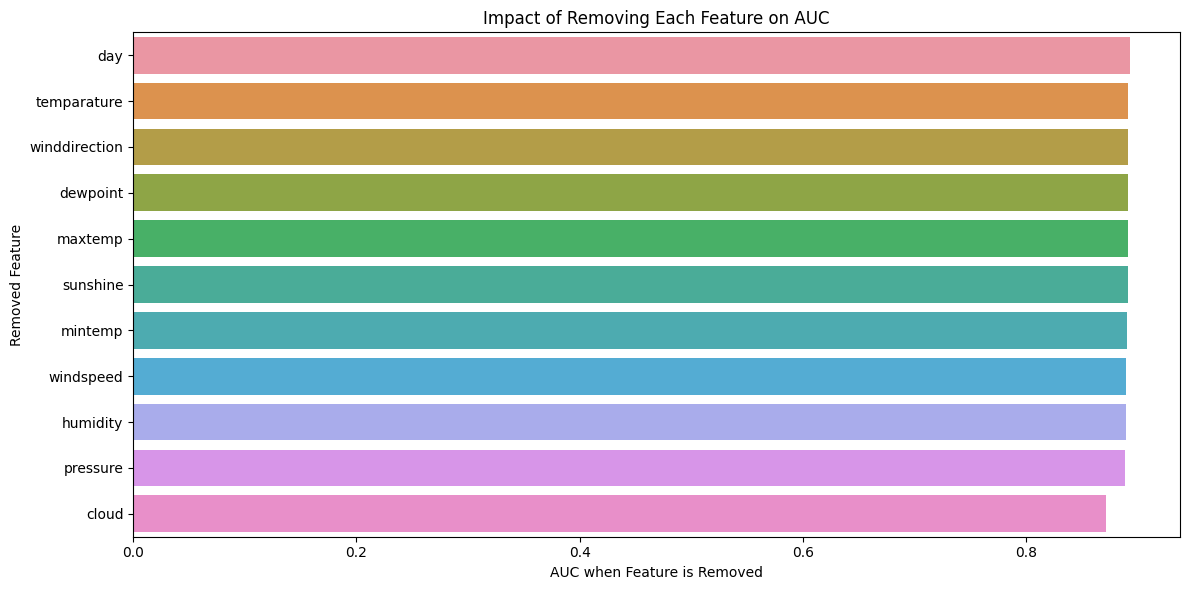

In [136]:
from sklearn.model_selection import cross_val_score

# Base feature list
base_features = df_train.columns.tolist()

# Store results
lofo_results = []

# Loop over each feature to remove it and evaluate model
for feature_to_remove in base_features:
    print(f"\n--- Training without feature: {feature_to_remove} ---")
    
    # Create reduced feature set
    reduced_features = [feat for feat in base_features if feat != feature_to_remove]
    
    X_reduced = df_train[reduced_features]
    
    # Train model with best params from Optuna
    model = lgb.LGBMClassifier(**study.best_params, random_state=SEED)
    
    # Cross-validation AUC
    scores = cross_val_score(model, X_reduced, train_y, cv=5, scoring='roc_auc', n_jobs=-1)
    mean_auc = scores.mean()
    print(f"AUC without '{feature_to_remove}': {mean_auc:.4f}")
    
    # Store result
    lofo_results.append({
        'Removed Feature': feature_to_remove,
        'AUC': mean_auc
    })

# Convert results to DataFrame
lofo_df = pd.DataFrame(lofo_results).sort_values(by='AUC', ascending=False)

# Display sorted results
print("\n===== Leave-One-Feature-Out AUC Results =====")
print(lofo_df)

# Plot AUC impact
plt.figure(figsize=(12, 6))
sns.barplot(data=lofo_df, x='AUC', y='Removed Feature')
plt.title('Impact of Removing Each Feature on AUC')
plt.xlabel('AUC when Feature is Removed')
plt.ylabel('Removed Feature')
plt.tight_layout()
plt.show()


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] feature_fraction is set=0.7048106210640472, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7048106210640472
[LightGBM] [Warning] lambda_l1 is set=0.43113207298492334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43113207298492334
[LightGBM] [Warning] lambda_l2 is set=1.6368965509101188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6368965509101188
[LightGBM] [Warning] bagging_fraction is set=0.5948159528332612, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5948159528332612
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Submission file written to: submission_lightgbm_optuna.csv


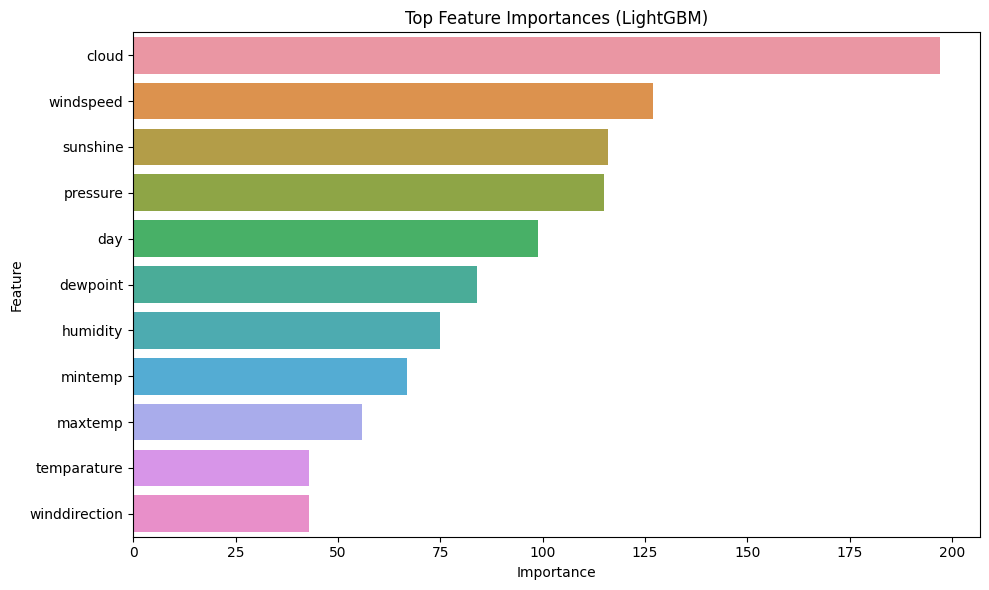

LightGBM model and features saved to lightgbm_optuna_with_features.pkl


In [137]:

# %% -------------------- Predict on Test and Create Submission --------------------
test_probs = best_lgb_model.predict_proba(df_test)[:, 1]
util.write_submission(test_df, test_probs, id_column='id', output_path='submission_lightgbm_optuna.csv', prediction_column='rainfall')


# %% -------------------- Feature Importance Plot --------------------
def plot_feature_importance(model, top_n=20):
    feature_importances = model.feature_importances_
    feature_names = df_train.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature')
    plt.title('Top Feature Importances (LightGBM)')
    plt.tight_layout()
    plt.show()

plot_feature_importance(best_lgb_model)


# %% -------------------- Export LightGBM Model for Stacking --------------------
# Save the trained model with feature list for stacking/ensembling
model_data = {'model': best_lgb_model, 'features': selected_columns.tolist()}
model_path = 'lightgbm_optuna_with_features.pkl'
joblib.dump(model_data, model_path)
print(f"LightGBM model and features saved to {model_path}")
